# DataLab Cup 2: CNN for Object Detection

Sao-Hsuan Lin

113062532

In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {gpus}")
    device = torch.device("cuda:3")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
print(f"Device: {device}")

Number of GPUs: 4
Device: cuda:3


In [3]:
classes_name = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np


class DatasetGenerator(Dataset):
    """
    Load PascalVOC 2007 dataset and create an input pipeline.
    - Reshapes images into 448 x 448
    - Converts [0, 1] to [-1, 1]
    - Supports shuffling and batching with DataLoader
    """

    def __init__(
        self, data_path, image_dir, max_objects_per_image, image_size
    ):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        self.max_objects_per_image = max_objects_per_image
        self.image_size = image_size
        self.image_dir = image_dir

        # Filling the record_list
        with open(data_path, "r") as input_file:
            for line in input_file:
                line = line.strip()
                ss = line.split(" ")
                self.image_names.append(ss[0])
                self.record_list.append([float(num) for num in ss[1:]])
                self.object_num_list.append(
                    min(len(self.record_list[-1]) // 5, max_objects_per_image)
                )

                # Padding or cropping the list as needed
                if len(self.record_list[-1]) < max_objects_per_image * 5:
                    self.record_list[-1] += [0.0, 0.0, 0.0, 0.0, 0.0] * (
                        max_objects_per_image - len(self.record_list[-1]) // 5
                    )
                elif len(self.record_list[-1]) > max_objects_per_image * 5:
                    self.record_list[-1] = self.record_list[-1][
                        : max_objects_per_image * 5
                    ]

        # Define image transformations
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((image_size, image_size), antialias=False),
                # transforms.Normalize(
                #     mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                # ),  # Rescale [0,1] to [-1,1]
                transforms.Lambda(lambda x: x / 255.0 * 2.0 - 1.0),
            ]
        )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        raw_labels = np.array(self.record_list[idx]).reshape(-1, 5)
        object_num = self.object_num_list[idx]

        # Load and process image
        image = Image.open(self.image_dir + image_name)
        w, h = image.size
        image = self.transform(image)

        # Process labels
        raw_labels = torch.tensor(raw_labels, dtype=torch.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        # Ratios for scaling to model input size
        height_ratio = self.image_size / float(h)
        width_ratio = self.image_size / float(w)

        # Scaled (normalized) labels for model input
        xcenter_scaled = (xmin + xmax) / 2.0 * width_ratio
        ycenter_scaled = (ymin + ymax) / 2.0 * height_ratio
        box_w_scaled = (xmax - xmin) * width_ratio
        box_h_scaled = (ymax - ymin) * height_ratio
        scaled_labels = torch.stack(
            [
                xcenter_scaled,
                ycenter_scaled,
                box_w_scaled,
                box_h_scaled,
                class_num,
            ],
            dim=1,
        )

        return image, scaled_labels, object_num


def create_data_loader(
    data_path,
    image_dir,
    batch_size,
    max_objects_per_image,
    image_size,
    shuffle=True,
):
    dataset = DatasetGenerator(
        data_path, image_dir, max_objects_per_image, image_size
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..255.0].


images: torch.Size([16, 3, 448, 448])
labels: torch.Size([16, 20, 5])
object_nums: torch.Size([16])


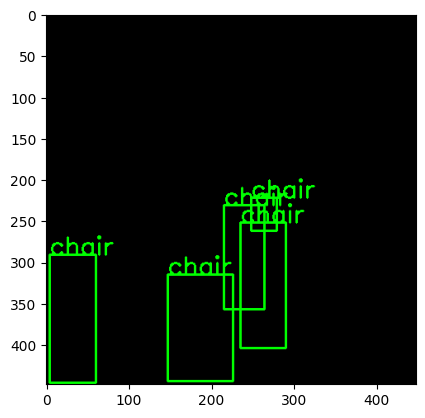

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

# common params
IMAGE_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
TRAIN_DATA_PATH = "./data/pascal_voc_training_data.txt"
TRAIN_IMAGE_DIR = "./data/VOCdevkit_train/VOC2007/JPEGImages/"
TEST_DATA_PATH = "./data/pascal_voc_testing_data.txt"
TEST_IMAGE_DIR = "./data/VOCdevkit_test/VOC2007/JPEGImages/"

# Test the data loader
data_loader = create_data_loader(
    TRAIN_DATA_PATH,
    TRAIN_IMAGE_DIR,
    BATCH_SIZE,
    MAX_OBJECTS_PER_IMAGE,
    IMAGE_SIZE,
    shuffle=False,
)
for i, (images, labels, object_nums) in enumerate(data_loader):
    print("images:", images.shape)
    print("labels:", labels.shape)
    print("object_nums:", object_nums.shape)

    np_img = images[0].numpy().copy()
    np_img = np_img + 1 / 2
    np_img = np_img.transpose(1, 2, 0)
    np_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))

    for j in range(int(object_nums[0])):
        x_center, y_center, box_w, box_h, class_num = labels[0, j]
        xmin, ymin, xmax, ymax = (
            x_center - box_w / 2,
            y_center - box_h / 2,
            x_center + box_w / 2,
            y_center + box_h / 2,
        )
        cv2.putText(
            np_img,
            classes_name[int(class_num)],
            (int(xmin), int(ymin)),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
        cv2.rectangle(
            np_img,
            (int(xmin), int(ymin)),
            (int(xmax), int(ymax)),
            (0, 255, 0),
            2,
        )
    plt.imshow(np_img)
    plt.show()
    break

## Object Detection Model (YOLO)

24 convolution layers followed by 2 fully connected layers.

Use a linear activation function for the final layer and all other layers use the following leaky rectified linear activation:

$$
f(x) = \begin{cases}
x & \text{if } x > 0 \\
0.1x & \text{otherwise}
\end{cases}
$$
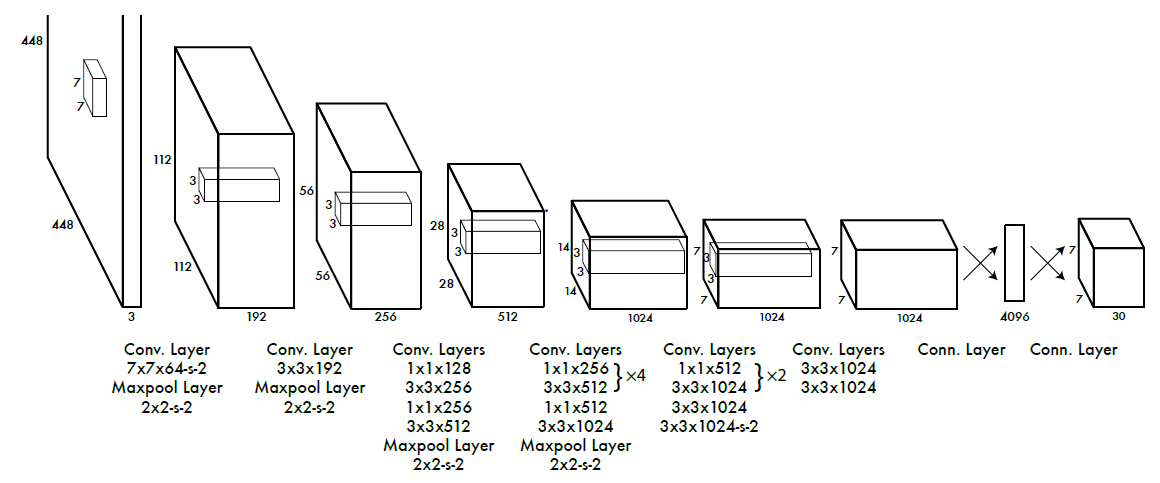

In [6]:
from torch import nn
import torch.nn.functional as F


class ConvLeakyReLU(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding
    ):
        super(ConvLeakyReLU, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True,
        )
        self.relu = nn.LeakyReLU(0.1)

        # nn.init.trunc_normal_(self.conv.weight, mean=0, std=0.05)

        # Kaiming initialization for Leaky ReLU
        nn.init.kaiming_normal_(
            self.conv.weight, a=0.1, mode="fan_out", nonlinearity="leaky_relu"
        )
        if self.conv.bias is not None:
            nn.init.constant_(self.conv.bias, 0)

    def forward(self, x):
        return self.relu(self.conv(x))

In [7]:
from torch import nn
import torch.nn.functional as F


class YOLO(nn.Module):
    def __init__(self):
        super(YOLO, self).__init__()

        self.layer1 = ConvLeakyReLU(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.layer2 = ConvLeakyReLU(
            64, 192, kernel_size=3, stride=1, padding=1
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.layer3 = ConvLeakyReLU(
            192, 128, kernel_size=1, stride=1, padding=0
        )
        self.layer4 = ConvLeakyReLU(
            128, 256, kernel_size=3, stride=1, padding=1
        )
        self.layer5 = ConvLeakyReLU(
            256, 256, kernel_size=1, stride=1, padding=0
        )
        self.layer6 = ConvLeakyReLU(
            256, 512, kernel_size=3, stride=1, padding=1
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.layer7 = ConvLeakyReLU(
            512, 256, kernel_size=1, stride=1, padding=0
        )
        self.layer8 = ConvLeakyReLU(
            256, 512, kernel_size=3, stride=1, padding=1
        )
        self.layer9 = ConvLeakyReLU(
            512, 256, kernel_size=1, stride=1, padding=0
        )
        self.layer10 = ConvLeakyReLU(
            256, 512, kernel_size=3, stride=1, padding=1
        )
        self.layer11 = ConvLeakyReLU(
            512, 256, kernel_size=1, stride=1, padding=0
        )
        self.layer12 = ConvLeakyReLU(
            256, 512, kernel_size=3, stride=1, padding=1
        )
        self.layer13 = ConvLeakyReLU(
            512, 256, kernel_size=1, stride=1, padding=0
        )
        self.layer14 = ConvLeakyReLU(
            256, 512, kernel_size=3, stride=1, padding=1
        )
        self.layer15 = ConvLeakyReLU(
            512, 512, kernel_size=1, stride=1, padding=0
        )
        self.layer16 = ConvLeakyReLU(
            512, 1024, kernel_size=3, stride=1, padding=1
        )
        self.pool4 = nn.MaxPool2d(2, 2)

        self.layer17 = ConvLeakyReLU(
            1024, 512, kernel_size=1, stride=1, padding=0
        )
        self.layer18 = ConvLeakyReLU(
            512, 1024, kernel_size=3, stride=1, padding=1
        )
        self.layer19 = ConvLeakyReLU(
            1024, 512, kernel_size=1, stride=1, padding=0
        )
        self.layer20 = ConvLeakyReLU(
            512, 1024, kernel_size=3, stride=1, padding=1
        )
        self.layer21 = ConvLeakyReLU(
            1024, 1024, kernel_size=3, stride=1, padding=1
        )
        self.layer22 = ConvLeakyReLU(
            1024, 1024, kernel_size=3, stride=2, padding=1
        )
        self.layer23 = ConvLeakyReLU(
            1024, 1024, kernel_size=3, stride=1, padding=1
        )
        self.layer24 = ConvLeakyReLU(
            1024, 1024, kernel_size=3, stride=1, padding=1
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024 * 7 * 7, 4096)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(4096, 1470)

        # nn.init.trunc_normal_(self.fc1.weight, mean=0, std=0.01)
        # nn.init.trunc_normal_(self.fc2.weight, mean=0, std=0.01)

        # Xavier initialization for fully connected layers
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.pool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.pool3(x)

        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.pool4(x)

        x = self.layer17(x)
        x = self.layer18(x)
        x = self.layer19(x)
        x = self.layer20(x)
        x = self.layer21(x)
        x = self.layer22(x)
        x = self.layer23(x)
        x = self.layer24(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)

        return x

In [8]:
# Test the model
model = YOLO().to(device)
images, labels, object_nums = next(iter(data_loader))
images = images.to(device)
labels = labels.to(device)
object_nums = object_nums.to(device)
output = model(images)
print(output.shape)
del model

torch.Size([16, 1470])


## Define Loss

In [9]:
import torch
from torch import nn
import torch.nn.functional as F


class YoloLoss(nn.Module):
    def __init__(
        self,
        cell_size,
        num_classes,
        boxes_per_cell,
        image_size,
        class_scale,
        object_scale,
        noobject_scale,
        coord_scale,
        device,
    ):
        super(YoloLoss, self).__init__()
        self.cell_size = cell_size
        self.num_classes = num_classes
        self.boxes_per_cell = boxes_per_cell
        self.image_size = image_size
        self.class_scale = class_scale
        self.object_scale = object_scale
        self.noobject_scale = noobject_scale
        self.coord_scale = coord_scale
        self.device = device

        # Define base_boxes and scale factors
        self.base_boxes = torch.zeros(
            [cell_size, cell_size, 1, 4], device=device
        )
        for y in range(cell_size):
            for x in range(cell_size):
                self.base_boxes[y, x, 0, :2] = torch.tensor(
                    [image_size / cell_size * x, image_size / cell_size * y]
                )
        self.base_boxes = self.base_boxes.repeat(1, 1, boxes_per_cell, 1)
        self.predict_boxes_multiple = torch.tensor(
            [
                image_size / cell_size,
                image_size / cell_size,
                image_size,
                image_size,
            ],
            device=device,
        )

    def forward(self, predicts, labels, objects_num):
        loss = 0.0
        batch_size = predicts.shape[0]
        for i in range(batch_size):
            predict = predicts[i, :, :, :]
            label = labels[i, :, :]
            object_num = objects_num[i]

            for j in range(object_num):
                loss += self._calculate_loss(predict, label[j : j + 1, :])

        return loss / batch_size

    def _calculate_loss(self, predict, label):
        """
        calculate loss
        Args:
        predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        label : [1, 5]  (x_center, y_center, w, h, class)
        """
        label = label.view(-1)

        # Step A: Calculate object mask
        object_mask = self._calculate_object_mask(label)

        # Step B: Center mask for the object
        center_mask = self._calculate_center_mask(label)

        # Step C: IOU between predicted and true boxes
        predict_boxes = predict[
            :, :, self.num_classes + self.boxes_per_cell :
        ].view(self.cell_size, self.cell_size, self.boxes_per_cell, 4)
        # cell position to pixel position
        predict_boxes = predict_boxes * self.predict_boxes_multiple
        # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
        predict_boxes = self.base_boxes + predict_boxes
        iou_predict_truth = self._iou(predict_boxes, label[:4])

        # Calculate tensors C and I
        C = iou_predict_truth * center_mask.unsqueeze(-1)
        I = (
            iou_predict_truth >= iou_predict_truth.max(dim=-1, keepdim=True)[0]
        ).float() * center_mask.unsqueeze(-1)
        no_I = 1 - I

        # Calculate predictions and ground truth
        p_C = predict[
            :, :, self.num_classes : self.num_classes + self.boxes_per_cell
        ]
        # calculate truth x, y, sqrt_w, sqrt_h 0-D
        x, y = label[0], label[1]
        sqrt_w, sqrt_h = torch.sqrt(torch.abs(label[2])), torch.sqrt(
            torch.abs(label[3])
        )
        # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
        p_x, p_y = predict_boxes[..., 0], predict_boxes[..., 1]
        p_sqrt_w, p_sqrt_h = torch.sqrt(
            torch.clamp(predict_boxes[..., 2], min=0, max=self.image_size)
        ), torch.sqrt(
            torch.clamp(predict_boxes[..., 3], min=0, max=self.image_size)
        )
        # calculate ground truth p 1-D tensor [NUM_CLASSES]
        P = F.one_hot(label[4].long(), self.num_classes).float()
        # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
        p_P = predict[:, :, : self.num_classes]

        # Loss calculations
        class_loss = (
            self._l2_loss(object_mask.unsqueeze(-1) * (p_P - P))
            * self.class_scale
        )
        object_loss = self._l2_loss(I * (p_C - C)) * self.object_scale
        noobject_loss = self._l2_loss(no_I * p_C) * self.noobject_scale
        coord_loss = (
            self._l2_loss(I * (p_x - x) / (self.image_size / self.cell_size))
            + self._l2_loss(I * (p_y - y) / (self.image_size / self.cell_size))
            + self._l2_loss(I * (p_sqrt_w - sqrt_w)) / self.image_size
            + self._l2_loss(I * (p_sqrt_h - sqrt_h)) / self.image_size
        ) * self.coord_scale
        return class_loss + object_loss + noobject_loss + coord_loss

    def _calculate_object_mask(self, label):
        # Converts (x_center, y_center, w, h) to (xmin, ymin, xmax, ymax)
        min_x = (label[0] - label[2] / 2) / (self.image_size / self.cell_size)
        max_x = (label[0] + label[2] / 2) / (self.image_size / self.cell_size)
        min_y = (label[1] - label[3] / 2) / (self.image_size / self.cell_size)
        max_y = (label[1] + label[3] / 2) / (self.image_size / self.cell_size)
        # Clamp values to [0, cell_size]
        min_x, min_y = torch.floor(min_x), torch.floor(min_y)
        max_x, max_y = torch.ceil(max_x).clamp(max=self.cell_size), torch.ceil(
            max_y
        ).clamp(max=self.cell_size)
        # Create object mask
        object_mask = torch.zeros(
            [self.cell_size, self.cell_size],
            dtype=torch.float32,
            device=self.device,
        )
        object_mask[int(min_y) : int(max_y), int(min_x) : int(max_x)] = 1.0
        return object_mask

    def _calculate_center_mask(self, label):
        center_x = torch.floor(label[0] / (self.image_size / self.cell_size))
        center_y = torch.floor(label[1] / (self.image_size / self.cell_size))
        center_mask = torch.zeros(
            [self.cell_size, self.cell_size],
            dtype=torch.float32,
            device=self.device,
        )
        center_mask[int(center_y), int(center_x)] = 1.0
        return center_mask

    def _iou(self, boxes1, boxes2):
        boxes1 = torch.stack(
            [
                boxes1[..., 0] - boxes1[..., 2] / 2,
                boxes1[..., 1] - boxes1[..., 3] / 2,
                boxes1[..., 0] + boxes1[..., 2] / 2,
                boxes1[..., 1] + boxes1[..., 3] / 2,
            ],
            dim=-1,
        )
        boxes2 = torch.stack(
            [
                boxes2[0] - boxes2[2] / 2,
                boxes2[1] - boxes2[3] / 2,
                boxes2[0] + boxes2[2] / 2,
                boxes2[1] + boxes2[3] / 2,
            ]
        )

        lu = torch.max(boxes1[..., :2], boxes2[:2])
        rd = torch.min(boxes1[..., 2:], boxes2[2:])
        intersection = (rd - lu).clamp(min=0)
        inter_area = intersection[..., 0] * intersection[..., 1]
        square1 = (boxes1[..., 2] - boxes1[..., 0]) * (
            boxes1[..., 3] - boxes1[..., 1]
        )
        square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])
        union_area = square1 + square2 - inter_area + 1e-6

        return inter_area / union_area

    def _l2_loss(self, x):
        return 0.5 * F.mse_loss(x, torch.zeros_like(x), reduction="sum")


# import numpy as np
# import torch

# # common params
# IMAGE_SIZE = 448
# BATCH_SIZE = 16
# NUM_CLASSES = 20
# MAX_OBJECTS_PER_IMAGE = 20

# # dataset params
# TRAIN_DATA_PATH = "./data/pascal_voc_training_data.txt"
# TRAIN_IMAGE_DIR = "./data/VOCdevkit_train/VOC2007/JPEGImages/"
# TEST_DATA_PATH = "./data/pascal_voc_testing_data.txt"
# TEST_IMAGE_DIR = "./data/VOCdevkit_test/VOC2007/JPEGImages/"

# # model params
# CELL_SIZE = 7
# BOXES_PER_CELL = 2
# OBJECT_SCALE = 1
# NOOBJECT_SCALE = 0.5
# CLASS_SCALE = 1
# COORD_SCALE = 5

# # training params
# START_EPOCH = 0
# LEARNING_RATE = 1e-4
# EPOCHS = 3

# with torch.no_grad():
#     model = YOLO().to(device)
#     model.eval()

#     def initialize_weights(module):
#         if isinstance(module, nn.Conv2d):
#             # nn.init.kaiming_normal_(module.weight, nonlinearity="leaky_relu")
#             if module.bias is not None:
#                 nn.init.constant_(module.bias, 0)

#     model.apply(initialize_weights)

#     # Test the data loader
#     data_loader = create_data_loader(
#         TRAIN_DATA_PATH,
#         TRAIN_IMAGE_DIR,
#         BATCH_SIZE,
#         MAX_OBJECTS_PER_IMAGE,
#         IMAGE_SIZE,
#         shuffle=False,
#     )
#     for i, (images, labels, object_nums) in enumerate(data_loader):
#         predicts = model(images.to(device))
#         class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
#         conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
#         class_probs = predicts[:, :class_end].view(
#             -1, CELL_SIZE, CELL_SIZE, NUM_CLASSES
#         )
#         confs = predicts[:, class_end:conf_end].view(
#             -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL
#         )
#         boxes = predicts[:, conf_end:].view(
#             -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4
#         )
#         predicts = torch.cat((class_probs, confs, boxes), dim=3).to(device)
#         labels = labels.to(device)
#         objects_num = object_nums.to(device)
#         break
#     print("predicts:", predicts.shape)
#     print("labels:", labels.shape)
#     print("objects_num:", objects_num.shape)

#     # Save tensors as .npz file to transfer to TensorFlow environment
#     np.savez(
#         "yolo_test_data.npz",
#         predicts=predicts.cpu().numpy(),
#         labels=labels.cpu().numpy(),
#         objects_num=objects_num.cpu().numpy(),
#     )

#     yolo_loss = YoloLoss(
#         CELL_SIZE,
#         NUM_CLASSES,
#         BOXES_PER_CELL,
#         IMAGE_SIZE,
#         CLASS_SCALE,
#         OBJECT_SCALE,
#         NOOBJECT_SCALE,
#         COORD_SCALE,
#         device=device,
#     )

#     loss = yolo_loss._calculate_loss(predicts[0], labels[0, 0:1])
#     print("Loss:", loss)
#     loss = yolo_loss(predicts, labels, objects_num)
#     print("Loss:", loss)

## Training

In [10]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
TRAIN_DATA_PATH = "./data/pascal_voc_training_data.txt"
TRAIN_IMAGE_DIR = "./data/VOCdevkit_train/VOC2007/JPEGImages/"
TEST_DATA_PATH = "./data/pascal_voc_testing_data.txt"
TEST_IMAGE_DIR = "./data/VOCdevkit_test/VOC2007/JPEGImages/"

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
START_EPOCH = 0
LEARNING_RATE = 1e-4
EPOCHS = 3

In [11]:
import torch
import os

# Directory for saving checkpoints
checkpoint_dir = "./ckpts/YOLO"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_name = "yolo_checkpoint"


# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, checkpoint_dir, checkpoint_name):
    checkpoint_path = os.path.join(
        checkpoint_dir, f"{checkpoint_name}_{epoch:03d}.pt"
    )
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        checkpoint_path,
    )
    print(f"Saved checkpoint for epoch {epoch} at {checkpoint_path}")


# Function to load checkpoint
def load_checkpoint(
    model, checkpoint_dir, checkpoint_name, optimizer=None, epoch=None
):
    if epoch is None:
        # Search for the latest checkpoint
        files = os.listdir(checkpoint_dir)
        files = [
            file
            for file in files
            if file.startswith(checkpoint_name) and file.endswith(".pt")
        ]
        if not files:
            print("No checkpoint found.")
            return
        files.sort()
        checkpoint_path = os.path.join(checkpoint_dir, files[-1])
    else:
        checkpoint_path = os.path.join(
            checkpoint_dir, f"{checkpoint_name}_{epoch:03d}.pt"
        )
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint for epoch {epoch} not found.")
        return
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if epoch is None:
        print(f"Loaded checkpoint from {checkpoint_path}")
    else:
        print(f"Loaded checkpoint for epoch {epoch} from {checkpoint_path}")

In [ ]:
import torch
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime

data_loader = create_data_loader(
    TRAIN_DATA_PATH,
    TRAIN_IMAGE_DIR,
    BATCH_SIZE,
    MAX_OBJECTS_PER_IMAGE,
    IMAGE_SIZE,
)
model = YOLO().to(device)
yolo_loss = YoloLoss(
    CELL_SIZE,
    NUM_CLASSES,
    BOXES_PER_CELL,
    IMAGE_SIZE,
    CLASS_SCALE,
    OBJECT_SCALE,
    NOOBJECT_SCALE,
    COORD_SCALE,
    device,
)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


# Training step function
def train_step(model, optimizer, images, labels, object_nums):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero out gradients

    # Forward pass
    outputs = model(images)
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = outputs[:, :class_end].view(
        -1, CELL_SIZE, CELL_SIZE, NUM_CLASSES
    )
    confs = outputs[:, class_end:conf_end].view(
        -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL
    )
    boxes = outputs[:, conf_end:].view(
        -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4
    )
    predicts = torch.cat([class_probs, confs, boxes], dim=3)

    # Compute loss
    loss = yolo_loss(predicts, labels, object_nums)
    loss_metric = loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss_metric


# Load checkpoint if available
if START_EPOCH > 0:
    load_checkpoint(
        model, checkpoint_dir, checkpoint_name, optimizer, START_EPOCH
    )


# Training loop
print(f"{datetime.now()}, start training.")
for epoch in range(START_EPOCH, EPOCHS + START_EPOCH):
    loss_metric_list = []

    for idx, (images, labels, object_nums) in enumerate(data_loader):
        images, labels, object_nums = (
            images.to(device),
            labels.to(device),
            object_nums.to(device),
        )
        loss_metric = train_step(model, optimizer, images, labels, object_nums)
        loss_metric_list.append(loss_metric)

        if idx % 50 == 0:
            print(
                f"Epoch {epoch+1:3d}, batch {idx+1:4d}, loss {loss_metric:10.4f}"
            )

    # Scheduler step after each epoch
    scheduler.step()

    # Print epoch loss
    avg_loss = sum(loss_metric_list) / len(loss_metric_list)
    print(f"Epoch {epoch+1:3d}, loss {avg_loss:10.4f}")

    # Save checkpoint
    save_checkpoint(
        epoch + 1, model, optimizer, checkpoint_dir, checkpoint_name
    )

2024-11-06 08:35:47.696845, start training.
Epoch   1, batch    1, loss    36.0085
Epoch   1, batch   51, loss    22.0827
Epoch   1, batch  101, loss    18.8250
Epoch   1, batch  151, loss    17.5351
Epoch   1, batch  201, loss    13.0470


## Predict Test data

In [ ]:
import torch


def process_outputs(outputs, conf_threshold=0.1):
    """
    Process YOLO outputs into bounding boxes, class, and confidence
    """
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL

    # Reshape and split outputs
    class_probs = outputs[:, :class_end].view(
        -1, CELL_SIZE, CELL_SIZE, NUM_CLASSES
    )
    confs = outputs[:, class_end:conf_end].view(
        -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL
    )
    boxes = outputs[:, conf_end:].view(
        -1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4
    )
    predicts = torch.cat([class_probs, confs, boxes], dim=3)

    # Extract components for the first image in batch
    p_classes = predicts[0, :, :, :NUM_CLASSES]
    C = predicts[0, :, :, NUM_CLASSES : NUM_CLASSES + BOXES_PER_CELL]
    coordinates = predicts[0, :, :, NUM_CLASSES + BOXES_PER_CELL :]

    # Reshape for element-wise multiplication to calculate P
    p_classes = p_classes.view(CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES)
    C = C.view(CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1)
    P = (
        C * p_classes
    )  # Shape [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, NUM_CLASSES]

    # # Find maximum confidence and corresponding indices
    # max_conf, index = torch.max(P.view(-1), dim=0)
    # index = torch.unravel_index(index, P.shape)

    # class_num = index[3]

    # # Reshape coordinates for easier access
    # coordinates = coordinates.view(CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4)
    # max_coordinate = coordinates[index[0], index[1], index[2], :]

    # # Calculate bounding box dimensions
    # xcenter = max_coordinate[0]
    # ycenter = max_coordinate[1]
    # w = max_coordinate[2]
    # h = max_coordinate[3]

    # xcenter = (index[1] + xcenter.item()) * (IMAGE_SIZE / float(CELL_SIZE))
    # ycenter = (index[0] + ycenter.item()) * (IMAGE_SIZE / float(CELL_SIZE))

    # w = w.item() * IMAGE_SIZE
    # h = h.item() * IMAGE_SIZE

    # xmin = xcenter - w / 2.0
    # ymin = ycenter - h / 2.0
    # xmax = xmin + w
    # ymax = ymin + h

    # return xmin, ymin, xmax, ymax, class_num.item(), max_conf.item()

    # Initialize lists to store results
    bboxes = []
    classes = []
    confidences = []

    # Iterate through each box and apply the confidence threshold
    for i in range(CELL_SIZE):
        for j in range(CELL_SIZE):
            for b in range(BOXES_PER_CELL):
                max_conf, class_idx = torch.max(P[i, j, b], dim=-1)

                if max_conf <= conf_threshold:
                    continue

                # Reshape coordinates for easier access
                coordinates = coordinates.view(
                    CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4
                )
                bbox = coordinates[i, j, b, :]

                # Calculate bounding box dimensions
                xcenter = bbox[0]
                ycenter = bbox[1]
                w = bbox[2]
                h = bbox[3]

                xcenter = (j + xcenter.item()) * (
                    IMAGE_SIZE / float(CELL_SIZE)
                )
                ycenter = (i + ycenter.item()) * (
                    IMAGE_SIZE / float(CELL_SIZE)
                )
                w = w.item() * IMAGE_SIZE
                h = h.item() * IMAGE_SIZE

                xmin = xcenter - w / 2.0
                ymin = ycenter - h / 2.0
                xmax = xmin + w
                ymax = ymin + h

                # Append results to lists
                bboxes.append((xmin, ymin, xmax, ymax))
                classes.append(class_idx.item())
                confidences.append(max_conf.item())

    return bboxes, classes, confidences

In [ ]:
from torch.utils.data import DataLoader, Dataset


class TestDataset(Dataset):
    def __init__(self, data_path, image_dir, image_size):
        self.image_names = []
        self.image_size = image_size
        self.image_dir = image_dir

        with open(data_path, "r") as input_file:
            for line in input_file:
                line = line.strip()
                self.image_names.append(line)

        self.transform = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),
            ]
        )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image = Image.open(self.image_dir + image_name).convert("RGB")
        image_height = image.height
        image_width = image.width
        image = self.transform(image)
        return image_name, image, image_height, image_width

In [ ]:
import os

OUTPUT_DIR = "./output"
PRED_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "predictions.txt")
EVAL_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "eval_results.txt")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Test data loader
data_loader = DataLoader(
    TestDataset(TEST_DATA_PATH, TEST_IMAGE_DIR, IMAGE_SIZE),
    batch_size=16,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

# Load model from checkpoint
model = YOLO().to(device)
load_checkpoint(model, checkpoint_dir, checkpoint_name)

# Test the model
# Output format: image_name {xmin_i ymin_i xmax_i ymax_i class_i confidence_score} (repeat number of objects times)
output_file = open(PRED_OUTPUT_PATH, "w")
for image_names, images, image_heights, image_widths in data_loader:
    images, image_heights, image_widths = (
        images.to(device),
        image_heights.to(device),
        image_widths.to(device),
    )
    outputs = model(images)

    for i in range(images.size(0)):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(
        #     outputs[i : i + 1]
        # )
        # xmin, ymin, xmax, ymax = (
        #     xmin * (image_widths[i : i + 1] / IMAGE_SIZE),
        #     ymin * (image_heights[i : i + 1] / IMAGE_SIZE),
        #     xmax * (image_widths[i : i + 1] / IMAGE_SIZE),
        #     ymax * (image_heights[i : i + 1] / IMAGE_SIZE),
        # )

        # # img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(
        #     image_names[i]
        #     + " %d %d %d %d %d %f\n"
        #     % (xmin, ymin, xmax, ymax, class_num, conf)
        # )

        bboxes, classes, confidences = process_outputs(outputs[i : i + 1], 0.1)
        for bbox, class_idx, conf in zip(bboxes, classes, confidences):
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = (
                xmin * (image_widths[i] / IMAGE_SIZE),
                ymin * (image_heights[i] / IMAGE_SIZE),
                xmax * (image_widths[i] / IMAGE_SIZE),
                ymax * (image_heights[i] / IMAGE_SIZE),
            )
            output_file.write(
                image_names[i]
                + " %d %d %d %d %d %f\n"
                % (xmin, ymin, xmax, ymax, class_idx, conf)
            )
output_file.close()

/tmp/ipykernel_3819264/2217477450.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Error(s) in loading state_dict for YOLO:
	Missing key(s) in state_dict: "layer1.conv.bias", "layer2.conv.bias", "layer3.conv.bias", "layer4.conv.bias", "layer5.conv.bias", "layer6.conv.bias", "layer7.conv.bias", "layer8.conv.bias", "layer9.conv.bias", "layer10.conv.bias", "layer11.conv.bias", "layer12.conv.bias", "layer13.conv.bias", "layer14.conv.bias", "layer15.conv.bias", "layer16.conv.bias", "layer17.conv.bias", "layer18.conv.bias", "layer19.conv.bias", "layer20.conv.bias", "layer21.conv.bias", "layer22.conv.bias", "layer23.conv.bias", "layer24.conv.bias". 
	Unexpected key(s) in state_dict: "layer1.bn.weight", "layer1.bn.bias", "layer1.bn.running_mean", "layer1.bn.running_var", "layer1.bn.num_batches_tracked", "layer2.bn.weight", "layer2.bn.bias", "layer2.bn.running_mean", "layer2.bn.running_var", "layer2.bn.num_batches_tracked", "layer3.bn.weight", "layer3.bn.bias", "layer3.bn.running_mean", "layer3.bn.running_var", "layer3.bn.num_batches_tracked", "layer4.bn.weight", "layer4.bn.bias", "layer4.bn.running_mean", "layer4.bn.running_var", "layer4.bn.num_batches_tracked", "layer5.bn.weight", "layer5.bn.bias", "layer5.bn.running_mean", "layer5.bn.running_var", "layer5.bn.num_batches_tracked", "layer6.bn.weight", "layer6.bn.bias", "layer6.bn.running_mean", "layer6.bn.running_var", "layer6.bn.num_batches_tracked", "layer7.bn.weight", "layer7.bn.bias", "layer7.bn.running_mean", "layer7.bn.running_var", "layer7.bn.num_batches_tracked", "layer8.bn.weight", "layer8.bn.bias", "layer8.bn.running_mean", "layer8.bn.running_var", "layer8.bn.num_batches_tracked", "layer9.bn.weight", "layer9.bn.bias", "layer9.bn.running_mean", "layer9.bn.running_var", "layer9.bn.num_batches_tracked", "layer10.bn.weight", "layer10.bn.bias", "layer10.bn.running_mean", "layer10.bn.running_var", "layer10.bn.num_batches_tracked", "layer11.bn.weight", "layer11.bn.bias", "layer11.bn.running_mean", "layer11.bn.running_var", "layer11.bn.num_batches_tracked", "layer12.bn.weight", "layer12.bn.bias", "layer12.bn.running_mean", "layer12.bn.running_var", "layer12.bn.num_batches_tracked", "layer13.bn.weight", "layer13.bn.bias", "layer13.bn.running_mean", "layer13.bn.running_var", "layer13.bn.num_batches_tracked", "layer14.bn.weight", "layer14.bn.bias", "layer14.bn.running_mean", "layer14.bn.running_var", "layer14.bn.num_batches_tracked", "layer15.bn.weight", "layer15.bn.bias", "layer15.bn.running_mean", "layer15.bn.running_var", "layer15.bn.num_batches_tracked", "layer16.bn.weight", "layer16.bn.bias", "layer16.bn.running_mean", "layer16.bn.running_var", "layer16.bn.num_batches_tracked", "layer17.bn.weight", "layer17.bn.bias", "layer17.bn.running_mean", "layer17.bn.running_var", "layer17.bn.num_batches_tracked", "layer18.bn.weight", "layer18.bn.bias", "layer18.bn.running_mean", "layer18.bn.running_var", "layer18.bn.num_batches_tracked", "layer19.bn.weight", "layer19.bn.bias", "layer19.bn.running_mean", "layer19.bn.running_var", "layer19.bn.num_batches_tracked", "layer20.bn.weight", "layer20.bn.bias", "layer20.bn.running_mean", "layer20.bn.running_var", "layer20.bn.num_batches_tracked", "layer21.bn.weight", "layer21.bn.bias", "layer21.bn.running_mean", "layer21.bn.running_var", "layer21.bn.num_batches_tracked", "layer22.bn.weight", "layer22.bn.bias", "layer22.bn.running_mean", "layer22.bn.running_var", "layer22.bn.num_batches_tracked", "layer23.bn.weight", "layer23.bn.bias", "layer23.bn.running_mean", "layer23.bn.running_var", "layer23.bn.num_batches_tracked", "layer24.bn.weight", "layer24.bn.bias", "layer24.bn.running_mean", "layer24.bn.running_var", "layer24.bn.num_batches_tracked". 

## Run Evaluation Metric

In [ ]:
from utils.evaluate import evaluate

evaluate(
    PRED_OUTPUT_PATH,
    EVAL_OUTPUT_PATH,
    "./data/evaluate/test_ans_encrypt.txt",
)

End Evalutation


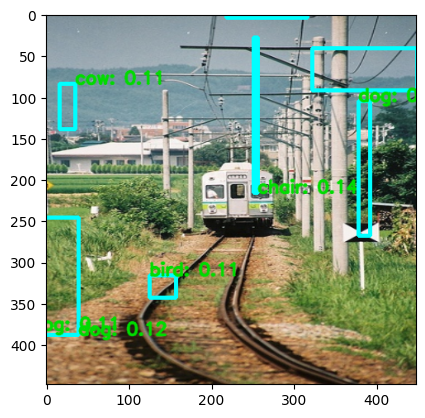

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
np_img = np.transpose(np_img, (0, 3, 1, 2))

y_pred = model(torch.tensor(np_img).to(device))
# xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
# class_name = classes_name[class_num]
# cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
# cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
bboxes, classes, confidences = process_outputs(y_pred, 0.1)
for bbox, class_idx, conf in zip(bboxes, classes, confidences):
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    txt = f"{classes_name[class_idx]}: {conf:.2f}"
    cv2.putText(resized_img, txt, (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 220, 0), 2, cv2.LINE_AA)

plt.imshow(resized_img)
plt.show()